In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")


### Repeating all the steps, removing nan values, negative and 0 values in sales

In [3]:
df_store = pd.read_csv('stores.csv') #store data
df_features = pd.read_csv('features.csv') #store data
df_train = pd.read_csv('train.csv') #store data

In [4]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')

In [5]:
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [6]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) 

In [7]:
df = df.loc[df['Weekly_Sales'] >= 1]

In [8]:
df = df.fillna(0)

In [9]:
nan_counts = df.isna().sum()
print(nan_counts)

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64


In [21]:
# 1. Copy the original DataFrame
df_encoded = df.copy()

# 2. Encode only 'IsHoliday'
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].replace({False: 0, True: 1})

# 3. Convert 'Date' to datetime and set as index
df_encoded['Date'] = pd.to_datetime(df_encoded['Date'])
df_en = df_encoded.set_index('Date')

# 4. Select numeric columns (Type, being categorical, will not be included)
df_num = df_en.select_dtypes(include=[np.number])

# 5. Resample weekly and compute the mean of remaining numeric columns
df_week = df_num.resample("W").mean()

print(df_week.head())



                Store       Dept  Weekly_Sales  IsHoliday  Temperature  \
Date                                                                     
2010-02-07  22.032620  44.123683  16904.816667        0.0    33.273381   
2010-02-14  22.006108  44.313539  16402.035914        1.0    33.370865   
2010-02-21  22.048534  44.282103  16271.621382        0.0    37.026084   
2010-02-28  22.018380  44.024847  14966.112570        0.0    38.627730   
2010-03-07  22.050477  43.965211  15986.601074        0.0    42.367138   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Date                                                                            
2010-02-07    2.717984        0.0        0.0        0.0        0.0        0.0   
2010-02-14    2.695979        0.0        0.0        0.0        0.0        0.0   
2010-02-21    2.673399        0.0        0.0        0.0        0.0        0.0   
2010-02-28    2.685440        0.0        0.0        0.0        0.0        0.

In [22]:

train_data = df_week[:int(0.7 * (len(df_week)))]
test_data = df_week[int(0.7 * (len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)



Train: (100, 14)
Test: (43, 14)


In [23]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [24]:
def wmae(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones(len(y_true))
    return np.sum(sample_weight * np.abs(y_true - y_pred)) / np.sum(sample_weight)

train_weights = np.where(X_train['IsHoliday'], 5, 1)
test_weights = np.where(X_test['IsHoliday'], 5, 1)

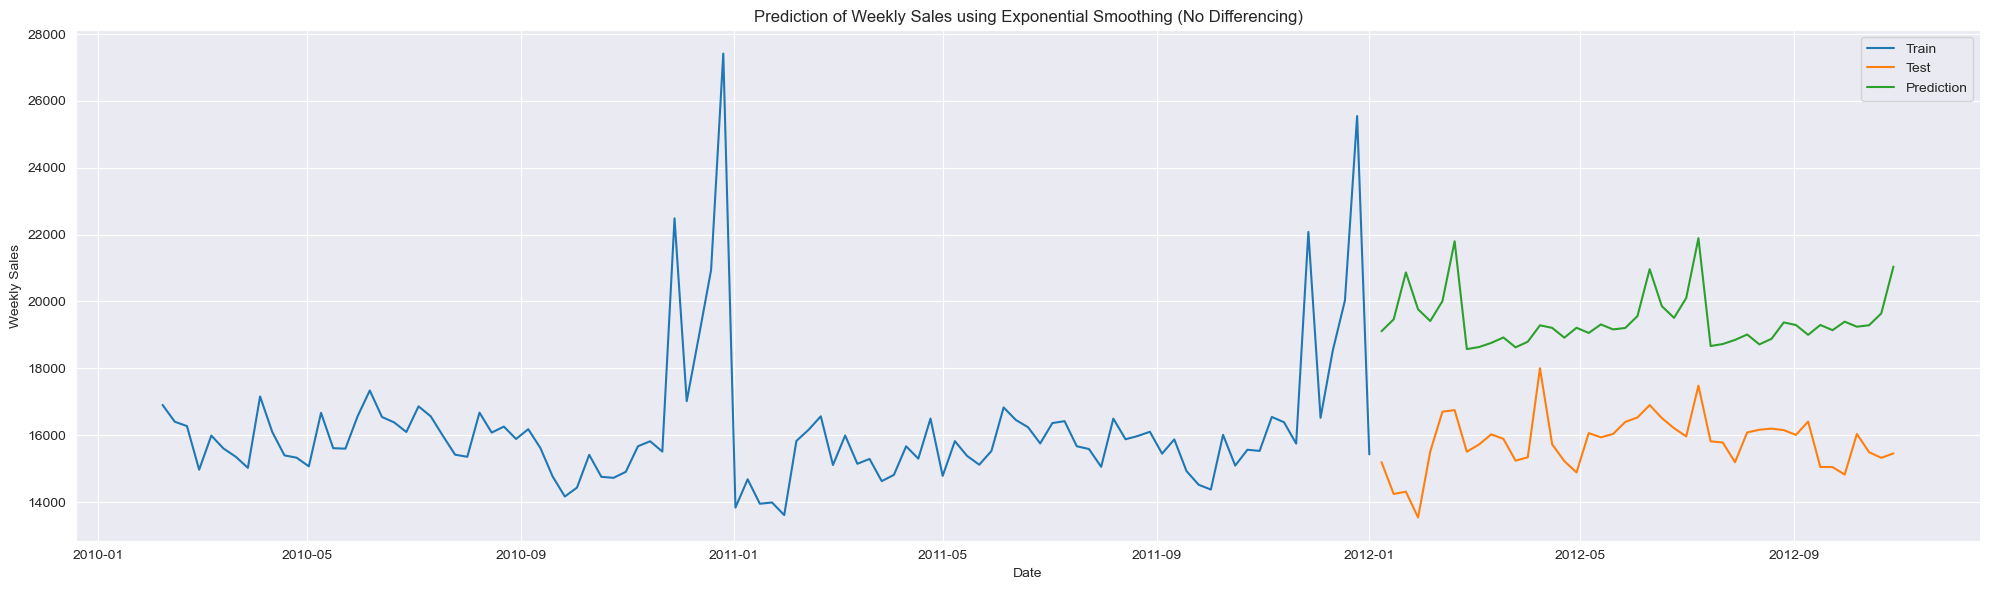

Test WMAE: 3537.050931777396


In [25]:

train_series = train_data['Weekly_Sales']
test_series = test_data['Weekly_Sales']

model = ExponentialSmoothing(train_series, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped_trend=True).fit() #Taking additive trend and seasonality.
# Forecast for the length of the test set
y_pred = model.forecast(len(test_series))

# Plot train, test, and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(train_series, label='Train')
plt.plot(test_series, label='Test')
plt.plot(y_pred, label='Prediction')
plt.title('Prediction of Weekly Sales using Exponential Smoothing (No Differencing)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Compute WMAE 
test_weights = np.where(test_data['IsHoliday'], 5, 1)
print("Test WMAE:", wmae(test_series.values, y_pred.values, sample_weight=test_weights))

### Previously exploring data and fitting the model i noticed that it is not stationary. Exponential smoothing does not require differencing or log transformation before applying it, but in some cases it can improve the model performance, so lets try to apply differencing.

In [26]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [27]:

# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()


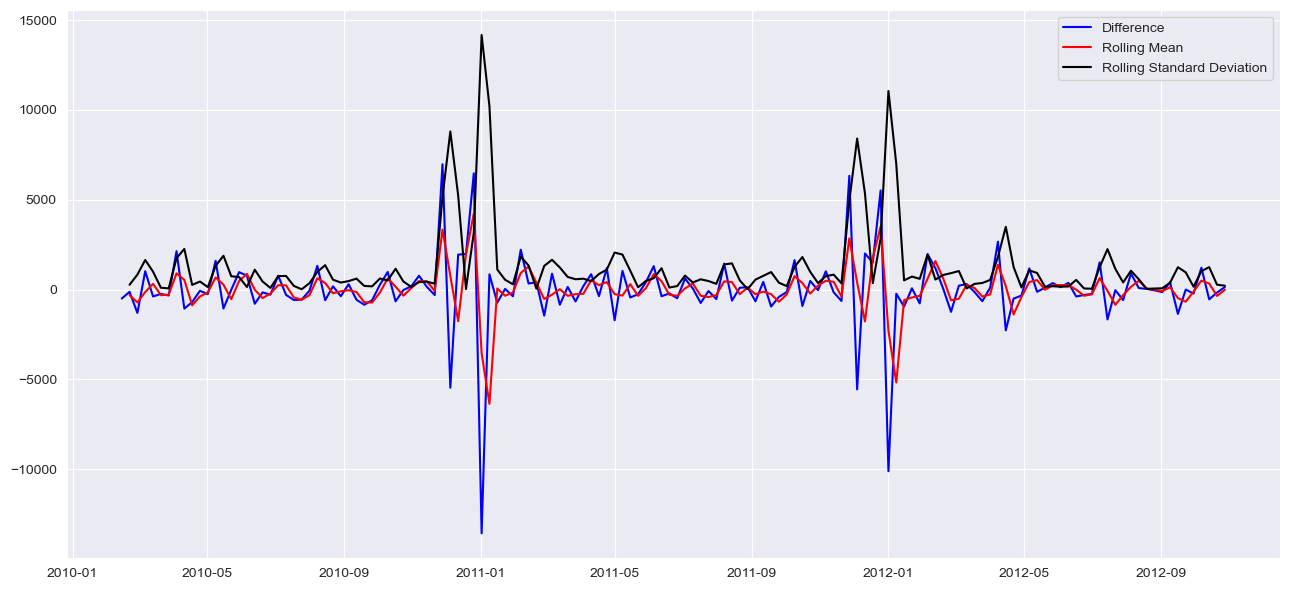

In [28]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()


### Overall, this plots tells me that we manage to remove some trend but periodic spikes suggest that we may have seasonal or other complex patterns in the data

### Lets fit Exponential Smoothing model to our diff data 

In [29]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [30]:
def wmae(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones(len(y_true))
    return np.sum(sample_weight * np.abs(y_true - y_pred)) / np.sum(sample_weight)

train_weights = np.where(X_train['IsHoliday'], 5, 1)
test_weights = np.where(X_test['IsHoliday'], 5, 1)

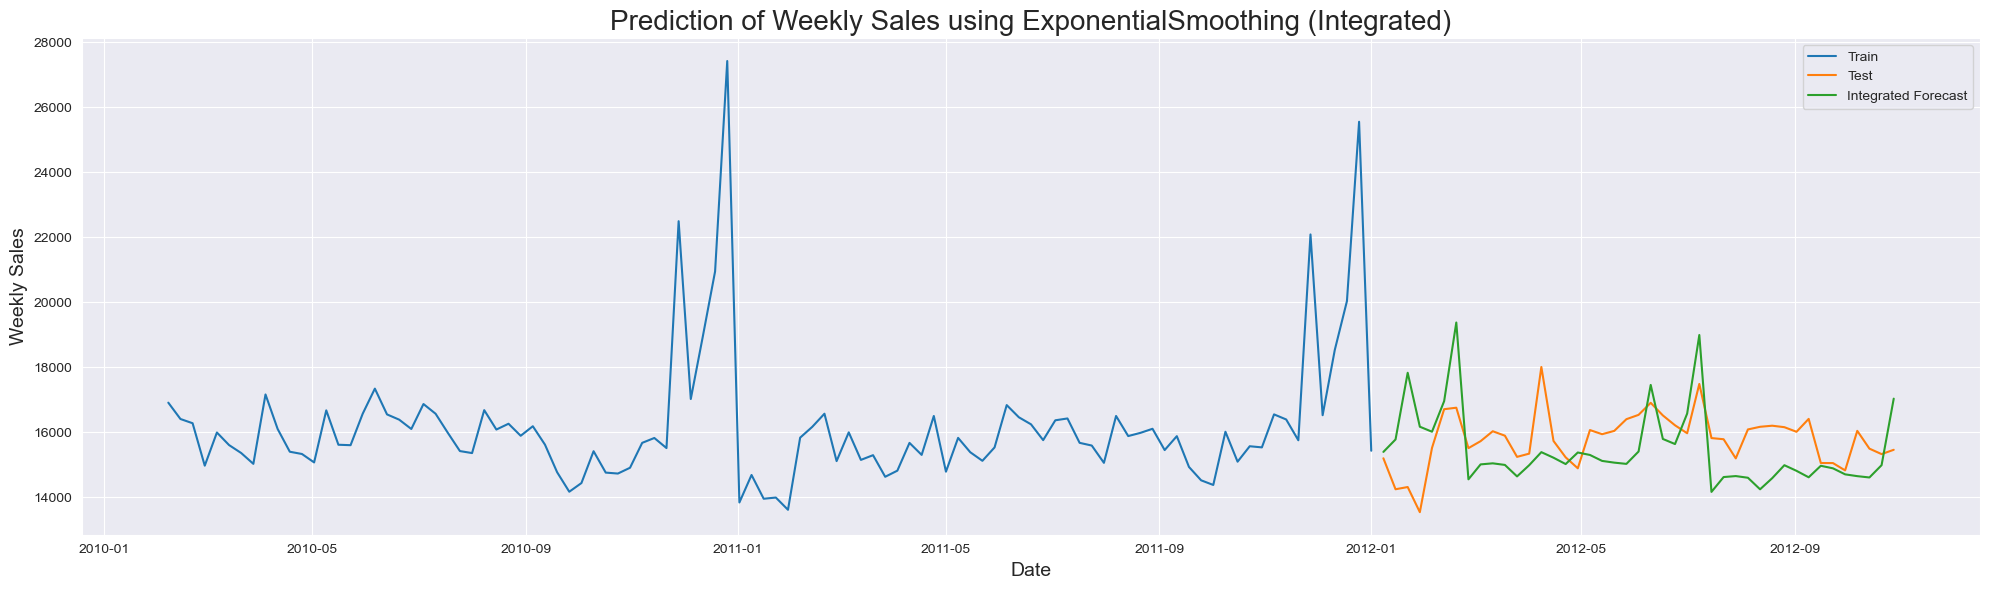

Test WMAE: 1057.1620772009203


In [31]:


model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped_trend=True).fit() #Taking additive trend and seasonality.
y_pred_diff = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

# Get the last observed value from the original data (before differencing)
last_train_value = df_week['Weekly_Sales'].iloc[int(0.7 * len(df_week)) - 1]

# Integrate forecasted differences back to original scale
y_pred_integrated = last_train_value + y_pred_diff.cumsum()
train_original = df_week['Weekly_Sales'][:int(0.7 * len(df_week))]
test_original = df_week['Weekly_Sales'][int(0.7 * len(df_week)):]

# Visualize original train, test and integrated forecast
plt.figure(figsize=(20, 6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing (Integrated)', fontsize=20)
plt.plot(train_original.index, train_original, label='Train')
plt.plot(test_original.index, test_original, label='Test')
plt.plot(test_original.index, y_pred_integrated, label='Integrated Forecast')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

test_wmae = wmae(test_original.values, y_pred_integrated.values, sample_weight=test_weights)
print("Test WMAE:", test_wmae)

### Exponential smoothing shows 1057 score which is roughly about 5-6 % error, overall its much better result that Gradient Boosting model.